**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
import os
import cv2
import numpy as np

import torch
import torch.nn as nn
import albumentations as A
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

from albumentations.pytorch import ToTensorV2
from torchsummary import summary
from torch.utils.data import Dataset
from tqdm.notebook import tqdm as tqdm
from torch.utils.data import Dataset

%matplotlib inline

In [2]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        im_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)
            
        augmented = self.transform(image=image,
                                   mask=mask)
        sample = {}
        sample['image'] = augmented['image']
        sample['mask'] = augmented['mask']

        return sample

In [3]:
X_train = get_paths("./data/train/images")
y_train = get_paths("./data/train/gt")

X_test = get_paths("./data/test/images")
y_test = get_paths("./data/test/gt")

train_transform = A.Compose([
    A.HorizontalFlip(),
    A.RandomRotate90(),
    A.RandomGamma(p=0.5),
#     A.ColorJitter(p=0.5),
    A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
    ], p=0.25),
    A.PadIfNeeded(min_height=512, min_width=512),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.PadIfNeeded(min_height=512, min_width=512),
    ToTensorV2(),
])

In [4]:
train_dataset = RoadDataset(X_train, y_train, train_transform)
test_dataset = RoadDataset(X_test, y_test, test_transform)

torch.Size([3, 512, 512]) torch.Size([512, 512])


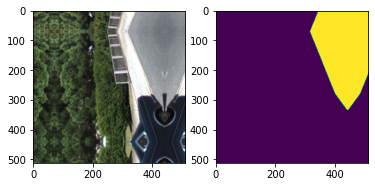

In [5]:
sample = train_dataset[4]
image = sample['image']
mask = sample['mask']

print(image.shape, mask.shape)
plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [6]:
print(f"Dataset length {len(train_dataset)}")

Dataset length 648


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!

### Model U-Net

In [7]:
class ConvLayer(nn.Module):
    
    def __init__(self, input_channels, output_channels, mid_channels=None, padding='same'):
        super().__init__()
        
        if mid_channels is None:
            mid_channels = output_channels
            
        self.conv1 = nn.Conv2d(in_channels=input_channels, 
                               out_channels=mid_channels,
                               kernel_size=(3, 3),
                               padding=padding)
        self.conv2 = nn.Conv2d(in_channels=mid_channels, 
                               out_channels=output_channels,
                               kernel_size=(3, 3),
                               padding=padding)
        
        self.dropout2d = nn.Dropout2d(0.2)
        self.use_dropout = True
        
        self.batchnorm1 = nn.BatchNorm2d(num_features=output_channels)
        self.batchnorm2 = nn.BatchNorm2d(num_features=output_channels)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        
    
    def forward(self, input):
        x = self.conv1(input)
        x = self.relu1(x)
        x = self.batchnorm1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.batchnorm2(x)
        
        if self.use_dropout:
            x = self.dropout2d(x)
        
        return x

In [8]:
class DownScaller(nn.Module):
    
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.maxpool = nn.MaxPool2d(kernel_size = (2, 2))
        self.conv_layer = ConvLayer(input_channels, output_channels)
    
    def forward(self, input):
        x = self.maxpool(input)
        x = self.conv_layer(x)

        return x

In [9]:
class UpScaler(nn.Module):
    
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.conv_layer = ConvLayer(input_channels, output_channels, input_channels // 2)
        self.conv_transposed = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=2, stride=2)   
    
    def forward(self, x1, x2):
        x1 = self.conv_transposed(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv_layer(x)
        
        return x
        

In [10]:
class UNet(nn.Module):
    
    def __init__(self):
        super().__init__()
                
        self.input_channel = 3
        self.output_channel = 16
        self.n_classes = 1
        
        self.conv1 = ConvLayer(self.input_channel, self.output_channel)
        
        self.down1 = DownScaller(self.output_channel * 1, self.output_channel * 2)
        self.down2 = DownScaller(self.output_channel * 2, self.output_channel * 4)
        self.down3 = DownScaller(self.output_channel * 4, self.output_channel * 8)
        self.down4 = DownScaller(self.output_channel * 8, self.output_channel * 16)
        self.down5 = DownScaller(self.output_channel * 16, self.output_channel * 32)
        
        self.up1 = UpScaler(self.output_channel * 32, self.output_channel * 16)
        self.up2 = UpScaler(self.output_channel * 16, self.output_channel * 8)
        self.up3 = UpScaler(self.output_channel * 8, self.output_channel * 4)
        self.up4 = UpScaler(self.output_channel * 4, self.output_channel * 2)
        self.up5 = UpScaler(self.output_channel * 2, self.output_channel * 1)

        self.conv3 = nn.Conv2d(self.output_channel * 1, self.n_classes, kernel_size=(3, 3), padding='same')
        self.sigmoid = nn.Sigmoid()
        
    
    def forward(self, input):
               
        x_1 = self.conv1(input)
        x_2 = self.down1(x_1)
        x_3 = self.down2(x_2)
        x_4 = self.down3(x_3)
        x_5 = self.down4(x_4)
        x_6 = self.down5(x_5)

        x_7 = self.up1(x_6, x_5)
        x_8 = self.up2(x_7, x_4)      
        x_9 = self.up3(x_8, x_3)
        x_10 = self.up4(x_9, x_2)
        x_11 = self.up5(x_10, x_1)
        
        output = self.conv3(x_11)
        output = self.sigmoid(output)
        
        return output

In [11]:
# CHECK
unet = UNet()
a = torch.rand([4, 3, 512, 512])
out = unet(a)

print(out.shape)

torch.Size([4, 1, 512, 512])


### Train U-Net

In [12]:
# model = UNet().to(device)
# summary(model, input_size=train_dataset[0]['image'].shape)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 10
EPOCHS = 40
learning_rate = 0.01

In [14]:
def calc_iou(pred, target):
    pred = pred.view(-1).contiguous()
    target = target.view(-1).contiguous()

    intersection = (pred * target).sum()                            
    iou = intersection / (pred.sum() + target.sum() - intersection) 
    
    return iou

def calc_dice(pred, target, alpha = 0.5):
    pred = pred.view(-1).contiguous()
    target = target.view(-1).contiguous()

    intersection = (pred * target).sum()                            
    dice = (2 * intersection + alpha) / (pred.sum() + target.sum() + alpha) 
    
    return dice

def calc_focal(pred, target, alpha=0.8, gamma=2, smooth=1):  
    pred = pred.view(-1)
    target = target.view(-1)

    BCE = F.binary_cross_entropy(pred, target, reduction='mean')
    BCE_EXP = torch.exp(-BCE)
    focal_loss = alpha * (1 - BCE_EXP) ** gamma * BCE

    return focal_loss

def calc_loss(pred, target):
#     weights = torch.eye(target.shape[0]) * 1 + 1
    
    bce_loss = F.binary_cross_entropy(pred, target.unsqueeze(1), 
#                                                   weight=weights.to(device)
                                                 )
    dice_loss = 1 - calc_dice(pred, target)
    
    loss = bce_loss + dice_loss
    
#     focal_loss = calc_focal(pred, target)
    
    return loss

In [15]:
def train_model(model, data_loader, optimizer):
    loss_history = []
    iou_history = []
    
    for batch in tqdm(data_loader, desc='TRAIN'):
        x_batch, y_batch = batch['image'].to(device).float(), batch['mask'].to(device).float()
        
        optimizer.zero_grad()
        
        output = model(x_batch)
        loss = calc_loss(output, y_batch)
        loss.backward()
           
        optimizer.step()
        
        loss_history.append(loss.item())
        iou_history.append(calc_iou(output, 
                                    y_batch).cpu().detach().numpy())
        
    print(f'Loss: {np.mean(loss_history):.3f} ± {np.std(loss_history):.3f}\
            IoU: {np.mean(iou_history):.3f}  ± {np.std(iou_history):.3f}')
    
    return model

In [16]:
@torch.no_grad()
def eval_model(model, data_loader, scheduler):
    loss_history = []
    iou_history = []
    
    for batch in tqdm(data_loader, desc='VALID'):
        x_batch, y_batch = batch['image'].to(device).float(), batch['mask'].to(device).float()
        
        output = model(x_batch)
        loss = calc_loss(output, y_batch)
        
        loss_history.append(loss.item() )
        iou_history.append(calc_iou(output, 
                                    y_batch).cpu().detach().numpy())
    
    scheduler.step(np.mean(loss_history))
    
    print(f'Loss: {np.mean(loss_history):.3f} ± {np.std(loss_history):.3f}\
            IoU: {np.mean(iou_history):.3f}  ± {np.std(iou_history):.3f}\n')
    
    image = test_dataset[0]['image'].to(device).float()
    pred_mask = model(image[None, :, :, :])
    
    plt.subplot(1, 2, 1)
    plt.imshow(image.cpu().permute(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    plt.show()

In [17]:
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE,
                                           num_workers=12)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, 
                                          num_workers=12)

In [18]:
# tensorboard
# print each loss
# use dilate
# use not custom loss

EPOCH:   0%|          | 0/40 [00:00<?, ?it/s]

-------------------------------------------------- Epoch 1 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.915 ± 0.322            IoU: 0.388  ± 0.099


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.779 ± 0.214            IoU: 0.468  ± 0.162



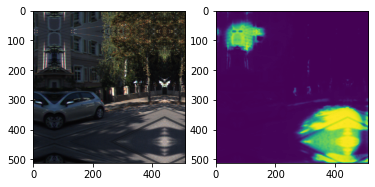

-------------------------------------------------- Epoch 2 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.618 ± 0.171            IoU: 0.531  ± 0.091


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 1.626 ± 0.806            IoU: 0.372  ± 0.210



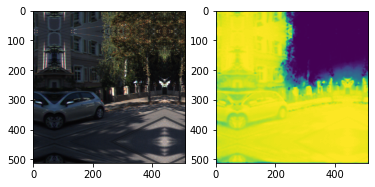

-------------------------------------------------- Epoch 3 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.557 ± 0.173            IoU: 0.575  ± 0.089


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.641 ± 0.186            IoU: 0.464  ± 0.159



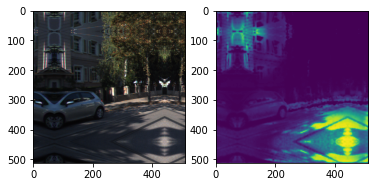

-------------------------------------------------- Epoch 4 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.588 ± 0.176            IoU: 0.554  ± 0.087


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.755 ± 0.270            IoU: 0.447  ± 0.174



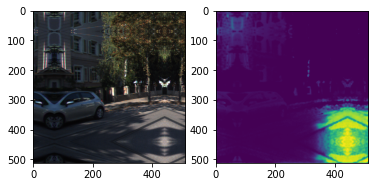

-------------------------------------------------- Epoch 5 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.549 ± 0.195            IoU: 0.578  ± 0.106


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.653 ± 0.460            IoU: 0.589  ± 0.247



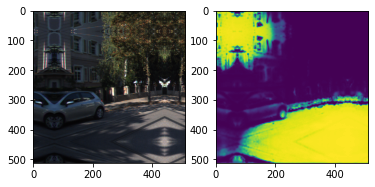

-------------------------------------------------- Epoch 6 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.528 ± 0.144            IoU: 0.595  ± 0.070


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 00006: reducing learning rate of group 0 to 2.5000e-03.
Loss: 2.095 ± 0.762            IoU: 0.114  ± 0.091



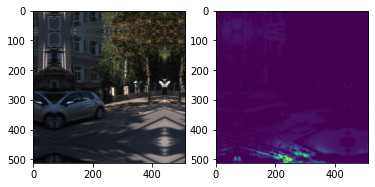

-------------------------------------------------- Epoch 7 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.502 ± 0.123            IoU: 0.613  ± 0.074


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.539 ± 0.334            IoU: 0.574  ± 0.226



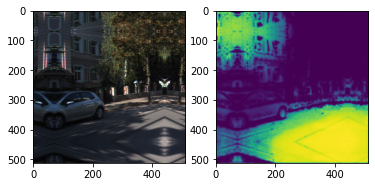

-------------------------------------------------- Epoch 8 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.497 ± 0.216            IoU: 0.617  ± 0.111


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.557 ± 0.348            IoU: 0.578  ± 0.228



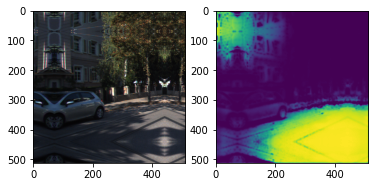

-------------------------------------------------- Epoch 9 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.464 ± 0.123            IoU: 0.633  ± 0.081


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.545 ± 0.341            IoU: 0.592  ± 0.228



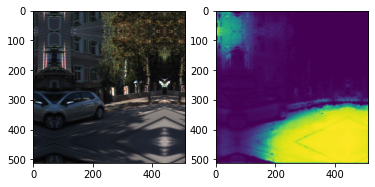

-------------------------------------------------- Epoch 10 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.482 ± 0.196            IoU: 0.624  ± 0.103


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.502 ± 0.310            IoU: 0.613  ± 0.223



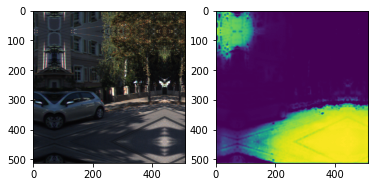

-------------------------------------------------- Epoch 11 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.454 ± 0.144            IoU: 0.645  ± 0.087


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.511 ± 0.323            IoU: 0.585  ± 0.226



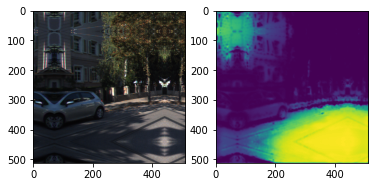

-------------------------------------------------- Epoch 12 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.477 ± 0.164            IoU: 0.626  ± 0.086


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.513 ± 0.305            IoU: 0.593  ± 0.222



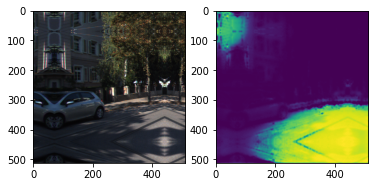

-------------------------------------------------- Epoch 13 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.448 ± 0.135            IoU: 0.645  ± 0.083


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 00013: reducing learning rate of group 0 to 6.2500e-04.
Loss: 0.518 ± 0.374            IoU: 0.609  ± 0.242



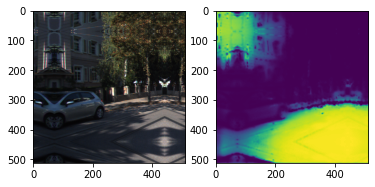

-------------------------------------------------- Epoch 14 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.459 ± 0.137            IoU: 0.637  ± 0.089


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.524 ± 0.353            IoU: 0.595  ± 0.237



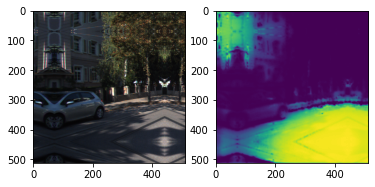

-------------------------------------------------- Epoch 15 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.467 ± 0.192            IoU: 0.633  ± 0.105


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.499 ± 0.327            IoU: 0.601  ± 0.230



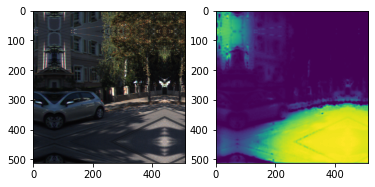

-------------------------------------------------- Epoch 16 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.447 ± 0.130            IoU: 0.645  ± 0.081


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.513 ± 0.353            IoU: 0.600  ± 0.237



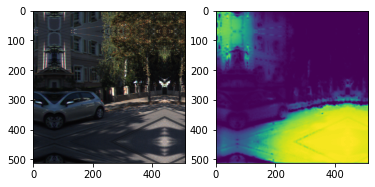

-------------------------------------------------- Epoch 17 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.443 ± 0.133            IoU: 0.645  ± 0.080


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.508 ± 0.332            IoU: 0.608  ± 0.229



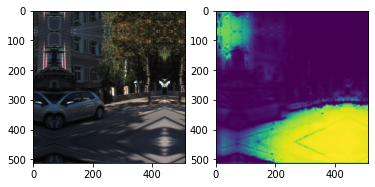

-------------------------------------------------- Epoch 18 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.406 ± 0.125            IoU: 0.672  ± 0.081


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.488 ± 0.326            IoU: 0.615  ± 0.230



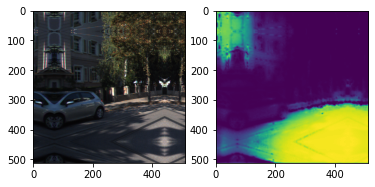

-------------------------------------------------- Epoch 19 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.416 ± 0.119            IoU: 0.669  ± 0.078


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.493 ± 0.302            IoU: 0.613  ± 0.221



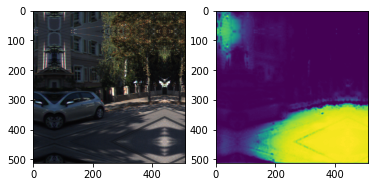

-------------------------------------------------- Epoch 20 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.408 ± 0.114            IoU: 0.673  ± 0.070


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.494 ± 0.331            IoU: 0.618  ± 0.229



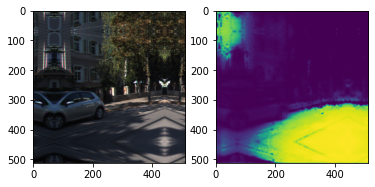

-------------------------------------------------- Epoch 21 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.417 ± 0.159            IoU: 0.669  ± 0.093


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 00021: reducing learning rate of group 0 to 1.5625e-04.
Loss: 0.498 ± 0.348            IoU: 0.619  ± 0.235



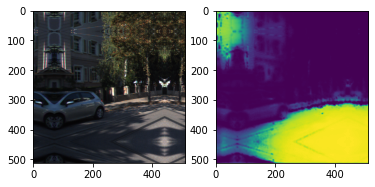

-------------------------------------------------- Epoch 22 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.405 ± 0.124            IoU: 0.673  ± 0.084


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.488 ± 0.342            IoU: 0.620  ± 0.235



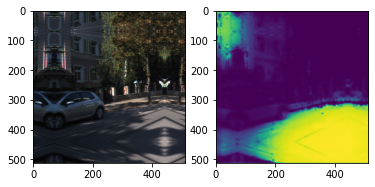

-------------------------------------------------- Epoch 23 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.440 ± 0.137            IoU: 0.656  ± 0.082


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.510 ± 0.330            IoU: 0.604  ± 0.227



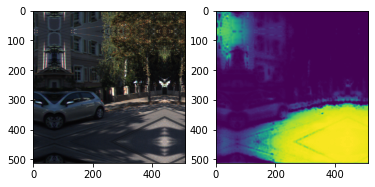

-------------------------------------------------- Epoch 24 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.411 ± 0.136            IoU: 0.670  ± 0.085


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.499 ± 0.354            IoU: 0.613  ± 0.237



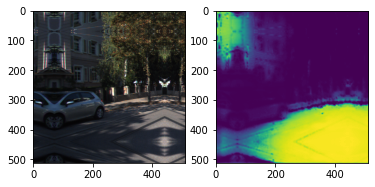

-------------------------------------------------- Epoch 25 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.425 ± 0.146            IoU: 0.660  ± 0.093


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 00025: reducing learning rate of group 0 to 3.9063e-05.
Loss: 0.489 ± 0.336            IoU: 0.615  ± 0.233



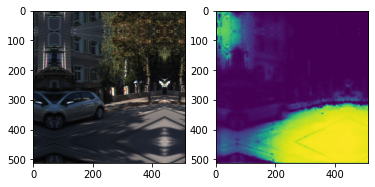

-------------------------------------------------- Epoch 26 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.424 ± 0.120            IoU: 0.660  ± 0.075


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.478 ± 0.319            IoU: 0.617  ± 0.230



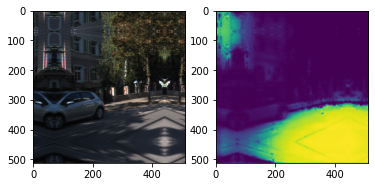

-------------------------------------------------- Epoch 27 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.417 ± 0.138            IoU: 0.667  ± 0.083


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.483 ± 0.333            IoU: 0.615  ± 0.233



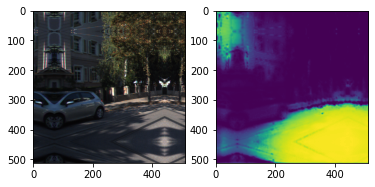

-------------------------------------------------- Epoch 28 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.456 ± 0.178            IoU: 0.644  ± 0.108


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.485 ± 0.339            IoU: 0.617  ± 0.235



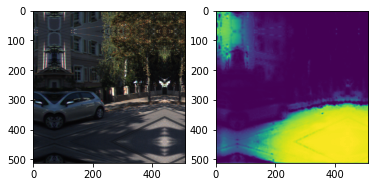

-------------------------------------------------- Epoch 29 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.416 ± 0.146            IoU: 0.665  ± 0.085


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 00029: reducing learning rate of group 0 to 9.7656e-06.
Loss: 0.496 ± 0.346            IoU: 0.613  ± 0.235



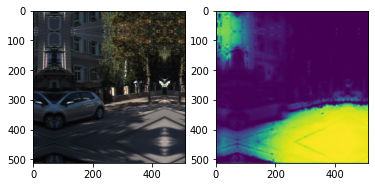

-------------------------------------------------- Epoch 30 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.409 ± 0.117            IoU: 0.670  ± 0.072


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.490 ± 0.342            IoU: 0.616  ± 0.235



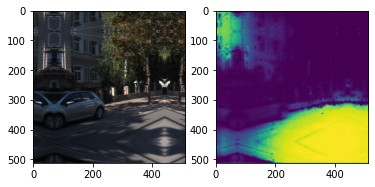

-------------------------------------------------- Epoch 31 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.441 ± 0.168            IoU: 0.654  ± 0.095


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.498 ± 0.355            IoU: 0.616  ± 0.239



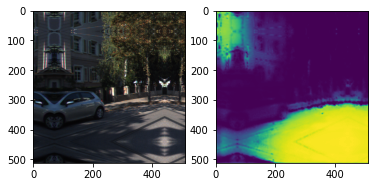

-------------------------------------------------- Epoch 32 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.408 ± 0.111            IoU: 0.670  ± 0.067


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 00032: reducing learning rate of group 0 to 2.4414e-06.
Loss: 0.488 ± 0.340            IoU: 0.617  ± 0.236



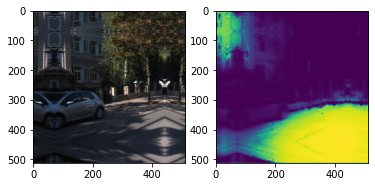

-------------------------------------------------- Epoch 33 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.408 ± 0.144            IoU: 0.672  ± 0.087


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.481 ± 0.323            IoU: 0.618  ± 0.231



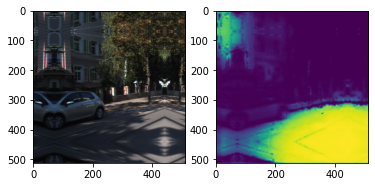

-------------------------------------------------- Epoch 34 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.416 ± 0.134            IoU: 0.667  ± 0.082


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.484 ± 0.313            IoU: 0.612  ± 0.226



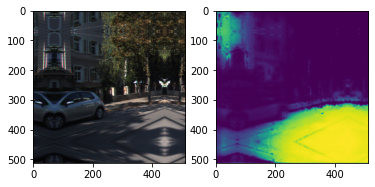

-------------------------------------------------- Epoch 35 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.403 ± 0.108            IoU: 0.673  ± 0.070


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 00035: reducing learning rate of group 0 to 6.1035e-07.
Loss: 0.509 ± 0.368            IoU: 0.611  ± 0.240



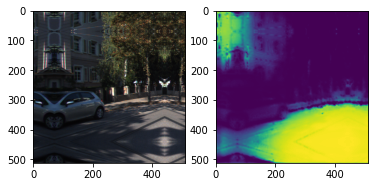

-------------------------------------------------- Epoch 36 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.417 ± 0.126            IoU: 0.665  ± 0.075


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.489 ± 0.340            IoU: 0.616  ± 0.235



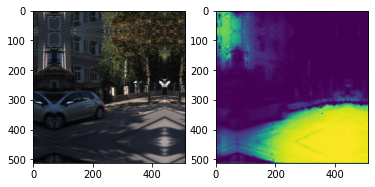

-------------------------------------------------- Epoch 37 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.425 ± 0.148            IoU: 0.661  ± 0.088


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.478 ± 0.317            IoU: 0.616  ± 0.230



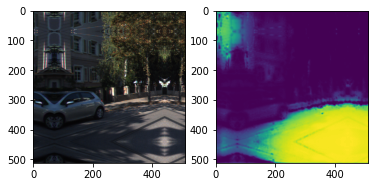

-------------------------------------------------- Epoch 38 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.422 ± 0.126            IoU: 0.662  ± 0.074


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Epoch 00038: reducing learning rate of group 0 to 1.5259e-07.
Loss: 0.485 ± 0.333            IoU: 0.618  ± 0.233



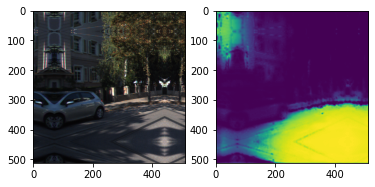

-------------------------------------------------- Epoch 39 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.418 ± 0.127            IoU: 0.664  ± 0.080


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.493 ± 0.348            IoU: 0.617  ± 0.238



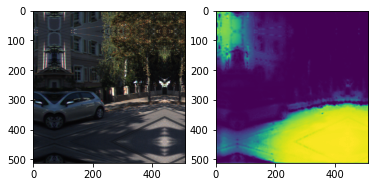

-------------------------------------------------- Epoch 40 / 40 --------------------------------------------------


TRAIN:   0%|          | 0/65 [00:00<?, ?it/s]

Loss: 0.414 ± 0.117            IoU: 0.668  ± 0.071


VALID:   0%|          | 0/22 [00:00<?, ?it/s]

Loss: 0.486 ± 0.331            IoU: 0.614  ± 0.233



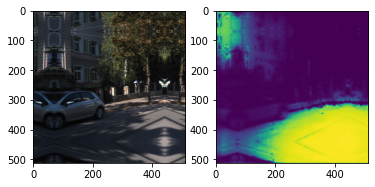

In [19]:
torch.cuda.empty_cache()

model = UNet().to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.25, patience=2, verbose=True)

for epoch in tqdm(range(EPOCHS), desc='EPOCH'):
    print('-' * 50, f'Epoch {epoch + 1} / {EPOCHS}', '-' * 50)
    
    model.train(True) 
    model = train_model(model, train_loader, optimizer)
    
    model.train(False) 
    eval_model(model, test_loader, scheduler)